In [1]:
import pandas as pd
import numpy as np

In [2]:
# Classifier Libraries
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

#import collections

# Other Libraries
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import Pipeline as imb_pipelineb
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.under_sampling import TomekLinks

# GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info
)

In [3]:
from src.data.load_data import read_params, read_data
from src.models.smote import preproc_cenario, balancing_pipe

from src.models.parameters import (
    parameters_bagg,
    parameters_smote
)

from src.models.clf_class import ClfSwitcher

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Lendo dados

In [6]:
config = read_params(config_path="../params.yaml")

safra_config = config["proc_data_config"]["safra_config"]
shuffle_config = config["proc_data_config"]["shuffle_config"]

dados safra e dados shuffle

In [7]:
x_safra_train = read_data('../'  + safra_config["x_train_csv"])
y_safra_train = read_data('../'  + safra_config["y_train_csv"])

x_shuffle_train = read_data('../'  + shuffle_config["x_train_csv"])
y_shuffle_train = read_data('../'  + shuffle_config["y_train_csv"])

In [14]:
x_safra_train.safra_contrato = x_safra_train.safra_contrato.apply(pd.to_datetime)
x_safra_train.head()

,safra_contrato,sexo,instrucao,idade,log_saldo_poup_avg,log_tempo_renda,log_renda_liquida,log_tempo_cp
0,2020-05-01,1,medio,22,11.05,6.77,7.43,5.29
1,2020-05-01,1,medio,30,10.29,6.10,8.11,4.90
2,2020-05-01,1,medio,47,4.58,8.20,7.98,4.30
3,2020-05-01,1,superior_pos,41,5.71,4.20,7.71,1.79
4,2020-05-01,0,medio,30,6.96,8.34,6.57,5.05


In [8]:
def mask_safra(x):
    if x == pd.to_datetime("2020-05-01"):
        return 0
    elif x == pd.to_datetime("2020-06-01"):
        return 1
    elif x == pd.to_datetime("2020-07-01"):
        return 2
    elif x == pd.to_datetime("2020-08-01"):
        return 3
    elif x == pd.to_datetime("2020-09-01"):
        return 4
    else:
        return 9

In [15]:
validacao = 'safra'
x_grid = x_safra_train.drop(columns='safra_contrato')
y_grid = y_safra_train.default_ate_12m

groups_cv = x_safra_train.safra_contrato.apply(mask_safra)
groups_cv = groups_cv[ groups_cv != 9]

cv_args = {"test_size": 1, "n_splits": 4, "window_type": "expanding"}
custom_cv = GroupTimeSeriesSplit(**cv_args)

#### Começando o grid search

Definindo validação cruzada:
- Shuffle
- Safra

In [17]:
shuffle_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=11)

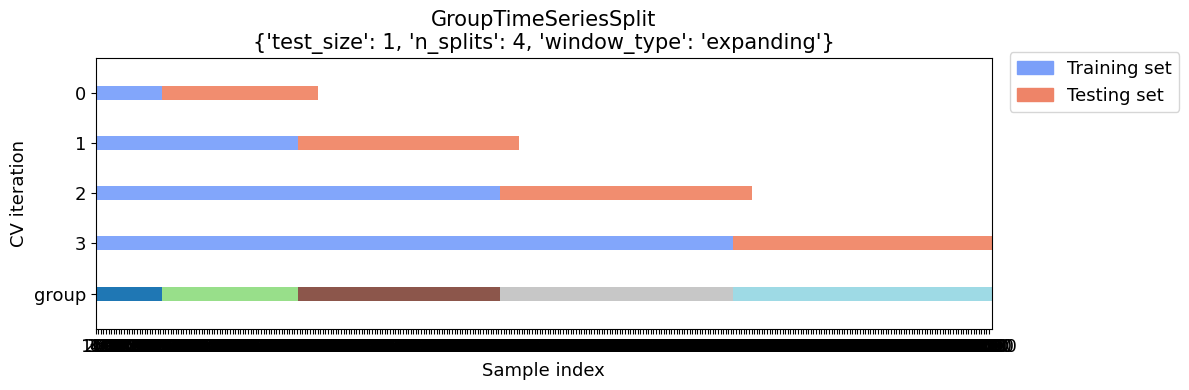

In [18]:
cv_args = {"test_size": 1, "n_splits": 4, "window_type": "expanding"}
plot_splits(x_safra_train, y_safra_train, groups_cv, **cv_args)

In [19]:
custom_cv = GroupTimeSeriesSplit(**cv_args)

Parametros teste:
- Cenario 1 (todas as variáveis)
- balanceamento bbagg

In [18]:
j = 1

j_pre_proc = preproc_cenario(cenario = j)
j_balanceamento = ["bbagg", "smote", "tomek"]

In [19]:
j_pipe = balancing_pipe(
    balanceamento = j_balanceamento[0],
    preproc_i = j_pre_proc,
    best_estimator = ClfSwitcher()
    )

GridSearch:
1. shuffle
2. safra (inclusão do parametro groups)

In [20]:
# k = modelos 
# 0: logistica, 1: KNN, 2: DecisioTree, 3: RAndomForest, 4: GradientBoosting
k = 0

In [21]:
# 1) shuffle
teste_shuffle = GridSearchCV(
    estimator=j_pipe,
   param_grid=parameters_bagg[k],
   scoring='recall',
    cv=shuffle_cv,
    verbose=0,
    #n_jobs=-1
).fit(x_shuffle_train, y_shuffle_train.default_ate_12m)

/home/cayan/Documentos/Trabalhos/pd_imbalanced/pd_imbalanced/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/home/cayan/Documentos/Trabalhos/pd_imbalanced/pd_imbalanced/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/home/cayan/Documentos/Trabalhos/pd_imbalanced/pd_imbalanced/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/home/cayan/Documentos/Trabalhos/pd_imbalanced/pd_imbalanced/lib/python3.10/site-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(
/home/cayan/Docu

In [12]:
#x_safra_train2 = x_safra_train.drop(columns='safra_contrato')

In [2]:
#teste_safra = GridSearchCV(
#    estimator=j_pipe,
#    param_grid=parameters_bagg[k],
#   scoring='recall',
#   cv=custom_cv,
#   verbose=3,
#   n_jobs=-1
#    ).fit(x_grid, y_grid, groups=groups_cv)
    #).fit(x_safra_train2, y_safra_train.values.ravel(), groups=groups_cv)

Mexendo com objetos retornados do GridSearchCV

- Abrindo objeto grid treinado

In [20]:
import pickle

In [21]:
validacao = ['shuffle', 'safra']
amostragem = ['bbagg', 'smote']
modelos = ['logistica', 'knn', 'decision_tree', 'random_forest', 'gradient_boosting']
cenario = ['cenario0', 'cenario1','cenario2', 'cenario3']

In [22]:
for k, cenario_k in enumerate(cenario):
    print(k, cenario_k)

0 cenario0
1 cenario1
2 cenario2
3 cenario3


- Shuffle

In [204]:

csv_final = []
#cenario_k = cenario[]

for i, values in enumerate(modelos):
    
    for k, cenario_k in enumerate(cenario):

        #cenario_k = cenario[k]
        pkl_file = '/home/cayan/Documentos/Trabalhos/pd_imbalanced/' + validacao + '_' + amostragem + '_mod' +  str(i) + '_' + cenario_k + '.pkl'

        #print(i, values, cenario_k)
        print(pkl_file)
       
        with open(pkl_file, 'rb') as handle:
            grid_mod = pickle.load(handle)

        #print(grid_mod.best_estimator_)
        grid_pred = grid_mod.best_estimator_.predict(x_shuffle_test)

        df_report = classification_report_imbalanced(
            y_shuffle_test,
            grid_pred,
            output_dict=True
            )

        df_0 = pd.DataFrame.from_dict(df_report[0], orient='index').T
        df_1 = pd.DataFrame.from_dict(df_report[1], orient='index').T

        lista_avg = list(df_report.values())   
        del lista_avg[:2]

        df_avg = pd.DataFrame(lista_avg).T
        df_avg.columns = ['pre', 'rec', 'spe', 'f1', 'geo', 'iba', 'sup']

        df_final = pd.concat(
            [
                df_0.reset_index(drop=True),
                df_1.reset_index(drop=True),
                df_avg
            ], axis=0
            )

        df_final['referencia'] = ['0', '1', 'medias']
        df_final['modelo'] = values
        df_final['cenario'] = cenario_k

        df_final = df_final[['cenario', 'modelo', 'referencia', 'pre', 'rec', 'spe', 'f1', 'geo', 'iba', 'sup']]
        csv_final.append(df_final)

    del grid_mod, grid_pred
    del df_report, df_0, df_1, lista_avg, df_avg, df_final

/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod0_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod0_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod0_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod0_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod1_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod1_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod1_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod1_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod2_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod2_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod2_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuffle_smote_mod2_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/shuff

In [210]:
df_csv = pd.concat(csv_final)
df_csv = df_csv[df_csv.referencia == '1']
df_csv

,cenario,modelo,referencia,pre,rec,spe,f1,geo,iba,sup
0,cenario0,logistica,1,0.09,0.60,0.58,0.16,0.59,0.35,965.00
0,cenario1,logistica,1,0.09,0.60,0.58,0.16,0.59,0.35,965.00
0,cenario2,logistica,1,0.09,0.62,0.55,0.15,0.58,0.34,965.00
0,cenario3,logistica,1,0.09,0.61,0.55,0.15,0.58,0.34,965.00
0,cenario0,knn,1,0.08,0.49,0.62,0.14,0.55,0.30,965.00
0,cenario1,knn,1,0.08,0.48,0.62,0.14,0.54,0.29,965.00
0,cenario2,knn,1,0.08,0.46,0.62,0.13,0.54,0.28,965.00
0,cenario3,knn,1,0.08,0.47,0.63,0.14,0.54,0.29,965.00
0,cenario0,decision_tree,1,0.10,0.62,0.60,0.17,0.61,0.37,965.00
0,cenario1,decision_tree,1,0.10,0.61,0.60,0.17,0.61,0.37,965.00


In [ ]:
df_csv.to_csv('shuffle_results_smote.csv')

- Safra

In [23]:
pkl_file = '/home/cayan/Documentos/Trabalhos/pd_imbalanced/' + validacao[1] + '_' + amostragem[0] + '_mod' +  str(0) + '_' + cenario[0] + '.pkl'
pkl_file

'/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod0_cenario0.pkl'

In [24]:
with open(pkl_file, 'rb') as handle:
    grid_mod = pickle.load(handle)

#print(grid_mod.best_estimator_)
#grid_pred = grid_mod.best_estimator_.predict(x_shuffle_test)

In [27]:
grid_df = pd.DataFrame(grid_mod.cv_results_).sort_values(by='mean_test_score', ascending=False)
grid_df.head().style.applymap(lambda x: 'white-space:nowrap')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__clf__estimator,param_base_estimator__clf__estimator__C,param_base_estimator__clf__estimator__penalty,param_base_estimator__clf__estimator__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
10,0.631010,0.242215,0.340618,0.076478,"LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear')",2.782559,l1,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 2.782559402207126, 'base_estimator__clf__estimator__penalty': 'l1', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.636964,0.614849,0.653179,0.616959,0.630488,0.015688,1
19,0.527850,0.158805,0.274476,0.045576,"LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear')",10000.000000,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 10000.0, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.633663,0.626450,0.640173,0.615497,0.628946,0.009157,2
15,0.590854,0.223198,0.320766,0.066844,"LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear')",166.810054,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 166.81005372000558, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.636964,0.631090,0.637283,0.608187,0.628381,0.011917,3
12,0.819891,0.245139,0.405739,0.070087,"LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear')",21.544347,l1,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 21.54434690031882, 'base_estimator__clf__estimator__penalty': 'l1', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.636964,0.633411,0.627168,0.612573,0.627529,0.009320,4
11,0.674104,0.265647,0.360565,0.105844,"LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear')",2.782559,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, penalty='l1', random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 2.782559402207126, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.636964,0.619490,0.625723,0.621345,0.625880,0.006787,5


Temos que pegar o grid_mid.predict() e os valores de test score em split0, split1, split2 e split2 do melhor estimador

In [28]:
col_split = ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score']

In [35]:
mask_rank1 = (grid_df.rank_test_score == 1)
time_window_recall = grid_df[mask_rank1][col_split].reset_index(drop=True)

time_window_recall

,split0_test_score,split1_test_score,split2_test_score,split3_test_score
0,0.64,0.61,0.65,0.62


In [36]:
x_shuffle_test = read_data('../'  + shuffle_config["x_test_csv"])
y_shuffle_test = read_data('../'  + shuffle_config["y_test_csv"])

x_safra_test = read_data('../'  + safra_config["x_test_csv"])
y_safra_test = read_data('../'  + safra_config["y_test_csv"])

In [37]:
x_safra_test = x_safra_test.drop(columns='safra_contrato')
#y_grid = y_safra_train.default_ate_12m

In [38]:
grid_pred = grid_mod.best_estimator_.predict(x_safra_test)

In [39]:
df_report = classification_report_imbalanced(
            y_safra_test,
            grid_pred,
            output_dict=True
            )

In [41]:
df_0 = pd.DataFrame.from_dict(df_report[0], orient='index').T
df_1 = pd.DataFrame.from_dict(df_report[1], orient='index').T

In [42]:
lista_avg = list(df_report.values())   
del lista_avg[:2]

In [43]:
df_avg = pd.DataFrame(lista_avg).T
df_avg.columns = ['pre', 'rec', 'spe', 'f1', 'geo', 'iba', 'sup']

df_final = pd.concat([df_0.reset_index(drop=True),
                      df_1.reset_index(drop=True),
                      df_avg], axis=0)

df_final['referencia'] = ['0', '1', 'medias']

In [45]:
df_final
df_final[df_final.referencia == '1']['rec']

,pre,rec,spe,f1,geo,iba,sup,referencia
0,0.96,0.56,0.63,0.71,0.59,0.35,9318.00,0
0,0.08,0.63,0.56,0.15,0.59,0.35,594.00,1
0,0.91,0.56,0.63,0.67,0.59,0.35,9912.00,medias


0   0.63
Name: rec, dtype: float64

In [46]:
time_window_recall['split4_test_score'] = df_final[df_final.referencia == '1']['rec']

In [47]:
time_window_recall

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.64,0.61,0.65,0.62,0.63


In [161]:
df_final['modelo'] = modelo[mod_k]
df_final['cenario'] = cenario[cenario_k]

In [49]:
validacao = ['shuffle', 'safra']
amostragem = ['bbagg', 'smote']
modelos = ['logistica', 'knn', 'decision_tree', 'random_forest', 'gradient_boosting']
cenario = ['cenario0', 'cenario1','cenario2', 'cenario3']

In [54]:
for i, values in enumerate(modelos):
    
    for k, cenario_k in enumerate(cenario):

        #cenario_k = cenario[k]
        pkl_file = '/home/cayan/Documentos/Trabalhos/pd_imbalanced/' + validacao[1] + '_' + amostragem[0] + '_mod' +  str(i) + '_' + cenario_k + '.pkl'
        print(pkl_file)

/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod0_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod0_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod0_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod0_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod1_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod1_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod1_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod1_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod2_cenario0.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod2_cenario1.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod2_cenario2.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod2_cenario3.pkl
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_bbagg_mod3_cenario0.pkl

In [80]:
# estamos corretos.
# depois de termos safra_bbagg_mod4_cenirio*, rodar esse loop
csv_final_safra = []
#cenario_k = cenario[]
time_window_recall_final = []
for i, values in enumerate(modelos):
    
    for k, cenario_k in enumerate(cenario):

        #cenario_k = cenario[k]
        pkl_file = '/home/cayan/Documentos/Trabalhos/pd_imbalanced/' + validacao[1] + '_' + amostragem[1] + '_mod' +  str(i) + '_' + cenario_k + '.pkl'

        #print(i, values, cenario_k)
        print(pkl_file)
       
        with open(pkl_file, 'rb') as handle:
            grid_mod = pickle.load(handle)

        #print(grid_mod.best_estimator_)
        grid_pred = grid_mod.best_estimator_.predict(x_safra_test)

        df_report = classification_report_imbalanced(
            y_safra_test,
            grid_pred,
            output_dict=True
            )

        df_0 = pd.DataFrame.from_dict(df_report[0], orient='index').T
        df_1 = pd.DataFrame.from_dict(df_report[1], orient='index').T

        lista_avg = list(df_report.values())   
        del lista_avg[:2]

        df_avg = pd.DataFrame(lista_avg).T
        df_avg.columns = ['pre', 'rec', 'spe', 'f1', 'geo', 'iba', 'sup']

        df_final = pd.concat(
            [
                df_0.reset_index(drop=True),
                df_1.reset_index(drop=True),
                df_avg
            ], axis=0
            )

        df_final['referencia'] = ['0', '1', 'medias']
        df_final['modelo'] = values
        df_final['cenario'] = cenario_k

        df_final = df_final[['cenario', 'modelo', 'referencia', 'pre', 'rec', 'spe', 'f1', 'geo', 'iba', 'sup']]
        csv_final_safra.append(df_final)

        # time window recall
        grid_df = pd.DataFrame(grid_mod.cv_results_).sort_values(by='mean_test_score', ascending=False)
        mask_rank1 = (grid_df.rank_test_score == 1)
        
        time_window_recall = grid_df[mask_rank1][col_split].reset_index(drop=True)
        time_window_recall['split4_test_score'] = df_final[df_final.referencia == '1']['rec']
        time_window_recall['modelo'] = values
        time_window_recall['cenario'] = cenario_k

        print(time_window_recall)

        time_window_recall_final.append(
            time_window_recall
        )

    del grid_mod, grid_pred, grid_df
    del df_report, df_0, df_1, lista_avg, df_avg, df_final, time_window_recall, mask_rank1

/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_smote_mod0_cenario0.pkl
   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0               0.67               0.65               0.64               0.63   

   split4_test_score     modelo   cenario  
0               0.69  logistica  cenario0  
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_smote_mod0_cenario1.pkl
   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0               0.68               0.66               0.65               0.61   

   split4_test_score     modelo   cenario  
0               0.68  logistica  cenario1  
/home/cayan/Documentos/Trabalhos/pd_imbalanced/safra_smote_mod0_cenario2.pkl
   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0               0.64               0.63               0.63               0.60   

   split4_test_score     modelo   cenario  
0               0.63  logistica  cenario2  
/home/cayan/Docu

In [82]:
df_csv = pd.concat(csv_final_safra)
df_csv = df_csv[df_csv.referencia == '1']
df_csv

,cenario,modelo,referencia,pre,rec,spe,f1,geo,iba,sup
0,cenario0,logistica,1,0.08,0.69,0.52,0.15,0.60,0.37,594.00
0,cenario1,logistica,1,0.09,0.68,0.53,0.15,0.60,0.37,594.00
0,cenario2,logistica,1,0.08,0.63,0.54,0.14,0.59,0.35,594.00
0,cenario3,logistica,1,0.08,0.64,0.54,0.14,0.59,0.35,594.00
0,cenario0,knn,1,0.07,0.46,0.61,0.12,0.53,0.28,594.00
0,cenario1,knn,1,0.07,0.47,0.61,0.12,0.54,0.29,594.00
0,cenario2,knn,1,0.07,0.48,0.61,0.13,0.54,0.29,594.00
0,cenario3,knn,1,0.07,0.49,0.61,0.13,0.55,0.30,594.00
0,cenario0,decision_tree,1,0.09,0.61,0.59,0.15,0.60,0.36,594.00
0,cenario1,decision_tree,1,0.09,0.56,0.64,0.16,0.60,0.36,594.00


In [83]:
#df_csv.to_csv('safra_results_bbaggg.csv')
df_csv.to_csv('safra_results_smote.csv')

In [84]:
# mudar bbagg / smote
#pd.concat(time_window_recall_final).to_csv('safra_timewindow_bbaggg.csv')
pd.concat(time_window_recall_final).to_csv('safra_timewindow_smote.csv')

In [35]:
abc_safra = pd.DataFrame(teste_safra.cv_results_)
abc_safra.sort_values(by='mean_test_score', ascending=False).style.applymap(lambda x: 'white-space:nowrap')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__clf__estimator,param_base_estimator__clf__estimator__C,param_base_estimator__clf__estimator__penalty,param_base_estimator__clf__estimator__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
11,0.656818,0.236063,0.227379,0.031466,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",2.782559,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 2.782559402207126, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.666667,0.640371,0.645954,0.618421,0.642853,0.017174,1
18,0.649642,0.232889,0.256563,0.033864,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",10000.000000,l1,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 10000.0, 'base_estimator__clf__estimator__penalty': 'l1', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.646865,0.645012,0.644509,0.609649,0.636509,0.015532,2
12,0.701016,0.295137,0.205504,0.024279,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",21.544347,l1,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 21.54434690031882, 'base_estimator__clf__estimator__penalty': 'l1', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.666667,0.619490,0.628613,0.615497,0.632567,0.020254,3
15,0.669608,0.251188,0.252464,0.040868,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",166.810054,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 166.81005372000558, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.613861,0.635731,0.651734,0.616959,0.629571,0.015289,4
13,0.581788,0.225842,0.258884,0.012268,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",21.544347,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 21.54434690031882, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.630363,0.624130,0.650289,0.611111,0.628973,0.014132,5
17,0.652268,0.220657,0.256468,0.042780,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",1291.549665,l2,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 1291.5496650148827, 'base_estimator__clf__estimator__penalty': 'l2', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.656766,0.612529,0.637283,0.606725,0.628326,0.020032,6
10,0.715842,0.263680,0.252192,0.036069,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",2.782559,l1,liblinear,"{'base_estimator__clf__estimator': LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear'), 'base_estimator__clf__estimator__C': 2.782559402207126, 'base_estimator__clf__estimator__penalty': 'l1', 'base_estimator__clf__estimator__solver': 'liblinear'}",0.623762,0.640371,0.643064,0.605263,0.628115,0.015123,7
16,0.661952,0.157154,0.268414,0.038088,"LogisticRegression(C=2.782559402207126, max_iter=1000, random_state=11, solver='liblinear')",1291